In [65]:
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
urdf_root_path = '/home/Go2py/Go2Py/assets'
urdf_path = '/home/Go2py/Go2Py/assets/urdf/go2_reordered.urdf'
robot = pin.RobotWrapper.BuildFromURDF(
urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

In [66]:
import sys
import mim_solvers
pinRef        = pin.LOCAL_WORLD_ALIGNED
FRICTION_CSTR = True
MU = 0.8     # friction coefficient

In [67]:
ee_frame_names = ['FL_foot', 'FR_foot', 'RL_foot', 'RR_foot']
rmodel = robot.model
rdata = robot.data
# # set contact frame_names and_indices
lfFootId = rmodel.getFrameId(ee_frame_names[0])
rfFootId = rmodel.getFrameId(ee_frame_names[1])
lhFootId = rmodel.getFrameId(ee_frame_names[2])
rhFootId = rmodel.getFrameId(ee_frame_names[3])

In [68]:
q0 = np.array([0.0, 0.0, 0.35, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

In [69]:
pinocchio.forwardKinematics(rmodel, rdata, q0)
pinocchio.updateFramePlacements(rmodel, rdata)
rfFootPos0 = rdata.oMf[rfFootId].translation
rhFootPos0 = rdata.oMf[rhFootId].translation
lfFootPos0 = rdata.oMf[lfFootId].translation
lhFootPos0 = rdata.oMf[lhFootId].translation 

In [70]:
comRef = (rfFootPos0 + rhFootPos0 + lfFootPos0 + lhFootPos0) / 4
comRef[2] = pinocchio.centerOfMass(rmodel, rdata, q0)[2].item() 

In [71]:
supportFeetIds = [lfFootId, rfFootId, lhFootId, rhFootId]
supportFeePos = [lfFootPos0, rfFootPos0, lhFootPos0, rhFootPos0]

In [72]:
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
nu = actuation.nu

In [73]:
comDes = []

N_ocp = 250 #100
dt = 0.02
T = N_ocp * dt
radius = 0.065
for t in range(N_ocp+1):
    comDes_t = comRef.copy()
    w = (2 * np.pi) * 0.2 # / T
    comDes_t[0] += radius * np.sin(w * t * dt) 
    comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
    comDes += [comDes_t]

In [74]:
import friction_utils
running_models = []
constraintModels = []

for t in range(N_ocp+1):
    contactModel = crocoddyl.ContactModelMultiple(state, nu)
    costModel = crocoddyl.CostModelSum(state, nu)

    # Add contact
    for frame_idx in supportFeetIds:
        support_contact = crocoddyl.ContactModel3D(state, frame_idx, np.array([0., 0., 0.]), pinRef, nu, np.array([0., 0.]))
        # print("contact name = ", rmodel.frames[frame_idx].name + "_contact")
        contactModel.addContact(rmodel.frames[frame_idx].name + "_contact", support_contact) 

    # Add state/control reg costs

    state_reg_weight, control_reg_weight = 1e-1, 1e-3

    freeFlyerQWeight = [0.]*3 + [500.]*3
    freeFlyerVWeight = [10.]*6
    legsQWeight = [0.01]*(rmodel.nv - 6)
    legsWWeights = [1.]*(rmodel.nv - 6)
    stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    


    stateResidual = crocoddyl.ResidualModelState(state, x0, nu)
    stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
    stateReg = crocoddyl.CostModelResidual(state, stateActivation, stateResidual)

    if t == N_ocp:
        costModel.addCost("stateReg", stateReg, state_reg_weight*dt)
    else:
        costModel.addCost("stateReg", stateReg, state_reg_weight)

    if t != N_ocp:
        ctrlResidual = crocoddyl.ResidualModelControl(state, nu)
        ctrlReg = crocoddyl.CostModelResidual(state, ctrlResidual)
        costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


    # Add COM task
    com_residual = crocoddyl.ResidualModelCoMPosition(state, comDes[t], nu)
    com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    com_track = crocoddyl.CostModelResidual(state, com_activation, com_residual)
    if t == N_ocp:
        costModel.addCost("comTrack", com_track, 1e5)
    else:
        costModel.addCost("comTrack", com_track, 1e5)

    constraintModelManager = crocoddyl.ConstraintModelManager(state, actuation.nu)
    if(FRICTION_CSTR):
        if(t != N_ocp):
            for frame_idx in supportFeetIds:
                name = rmodel.frames[frame_idx].name + "_contact"
                residualFriction = friction_utils.ResidualFrictionCone(state, name, MU, actuation.nu)
                constraintFriction = crocoddyl.ConstraintModelResidual(state, residualFriction, np.array([0.]), np.array([np.inf]))
                constraintModelManager.addConstraint(name + "friction", constraintFriction)

    dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contactModel, costModel, constraintModelManager, 0., True)
    model = crocoddyl.IntegratedActionModelEuler(dmodel, dt)

    running_models += [model]


In [75]:
# Create shooting problem
ocp = crocoddyl.ShootingProblem(x0, running_models[:-1], running_models[-1])

solver = mim_solvers.SolverCSQP(ocp)
solver.max_qp_iters = 1000
max_iter = 500
solver.with_callbacks = True
solver.use_filter_line_search = False
solver.termination_tolerance = 1e-4
solver.eps_abs = 1e-6
solver.eps_rel = 1e-6

In [76]:
xs = [x0]*(solver.problem.T + 1)
us = solver.problem.quasiStatic([x0]*solver.problem.T) 
solver.solve(xs, us, max_iter)   

True

In [93]:
nq, nv, N = rmodel.nq, rmodel.nv, len(xs) 
jointPos_sol = []
jointVel_sol = []
jointAcc_sol = []
jointTorques_sol = []
centroidal_sol = []

x = []
for time_idx in range (N):
    q, v = xs[time_idx][:nq], xs[time_idx][nq:]
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.computeCentroidalMomentum(rmodel, rdata, q, v)
    centroidal_sol += [
        np.concatenate(
            [pin.centerOfMass(rmodel, rdata, q, v), np.array(rdata.hg.linear), np.array(rdata.hg.angular)]
            )
            ]
    jointPos_sol += [q]
    jointVel_sol += [v]
    x += [xs[time_idx]]
    if time_idx < N-1:
        jointAcc_sol +=  [solver.problem.runningDatas[time_idx].xnext[nq::]] 
        jointTorques_sol += [us[time_idx]]




sol = {'x':x, 'centroidal':centroidal_sol, 'jointPos':jointPos_sol, 
                    'jointVel':jointVel_sol, 'jointAcc':jointAcc_sol, 
                    'jointTorques':jointTorques_sol}       

for frame_idx in supportFeetIds:
    # print('extract foot id ', frame_idx, "_name = ", rmodel.frames[frame_idx].name)
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    datas = [solver.problem.runningDatas[i].differential.multibody.contacts.contacts[ct_frame_name] for i in range(N-1)]
    ee_forces = [datas[k].f.vector for k in range(N-1)] 
    sol[ct_frame_name] = [ee_forces[i] for i in range(N-1)]     
    

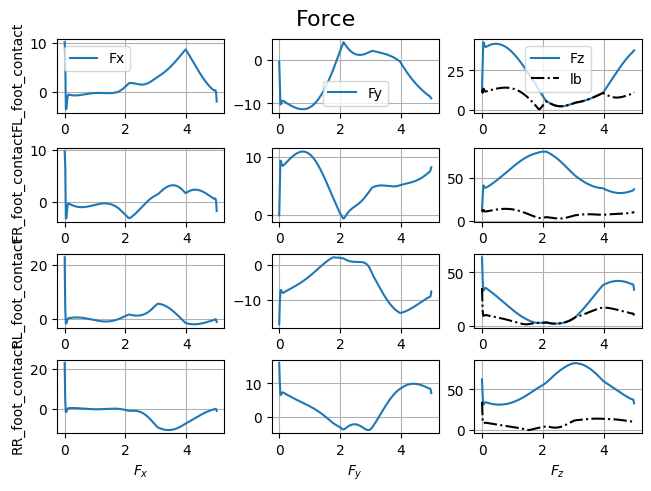

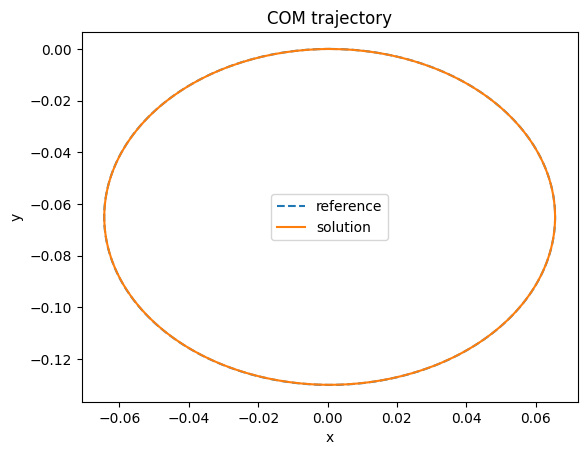

In [97]:
import matplotlib.pyplot as plt
constrained_sol = sol
time_lin = np.linspace(0, T, solver.problem.T)
fig, axs = plt.subplots(4, 3, constrained_layout=True)
for i, frame_idx in enumerate(supportFeetIds):
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    forces = np.array(constrained_sol[ct_frame_name])
    axs[i, 0].plot(time_lin, forces[:, 0], label="Fx")
    axs[i, 1].plot(time_lin, forces[:, 1], label="Fy")
    axs[i, 2].plot(time_lin, forces[:, 2], label="Fz")
    # Add friction cone constraints 
    Fz_lb = (1./MU)*np.sqrt(forces[:, 0]**2 + forces[:, 1]**2)
    # Fz_ub = np.zeros(time_lin.shape)
    # axs[i, 2].plot(time_lin, Fz_ub, 'k-.', label='ub')
    axs[i, 2].plot(time_lin, Fz_lb, 'k-.', label='lb')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].set_ylabel(ct_frame_name)
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()

axs[3, 0].set_xlabel(r"$F_x$")
axs[3, 1].set_xlabel(r"$F_y$")
axs[3, 2].set_xlabel(r"$F_z$")
fig.suptitle('Force', fontsize=16)


comDes = np.array(comDes)
centroidal_sol = np.array(constrained_sol['centroidal'])
plt.figure()
plt.plot(comDes[:, 0], comDes[:, 1], "--", label="reference")
plt.plot(centroidal_sol[:, 0], centroidal_sol[:, 1], label="solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("COM trajectory")
plt.show()